In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
# 전처리 
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import datetime
import os
import itertools

from sklearn.preprocessing import StandardScaler,MinMaxScaler

# 시각화
from matplotlib import pyplot as plt
from matplotlib import rc
import seaborn as sns

# 모델 
import fbprophet as Prophet
from sklearn.linear_model import LinearRegression, Ridge

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import LSTM, SimpleRNN, GRU

# bagging
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# boosting
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 보간
from scipy import interpolate
from scipy.interpolate import splrep, splev

'구분'은 공급사이지만 영업 비밀에 해당하여 비식별화 처리된 데이터이고,  
'공급량'은 영업비밀에 해당하여 원데이터와 유사한 패턴을 갖도록 처리된 데이터입니다.

# 전처리
- 공급사 구분 분류
- train, test 나누기

In [ ]:
path="/gdrive/My Drive/Colab Notebooks/dacon/gas_supply"
df_train=pd.read_csv(path+"/train.csv",encoding='cp949')
df_test=pd.read_csv(path+"/test.csv")
sample_df=pd.read_csv(path+"/sample_submission.csv")

train_size=len(df_train)
test_size=len(df_test)

L=['A', 'B', 'C', 'D', 'E', 'G', 'H']
a_to_num={"A":0,"B":1,"C":2,"D":3,"E":4,"G":5,"H":6}
location_size=len(L)

train_size_per=int(train_size/location_size)
test_size_per=int(test_size/location_size)

df_train_dict={}
for t in L:
    df_train_dict[t]=df_train[df_train["구분"]==t]
    df_train_dict[t]=df_train_dict[t].reset_index().drop(["index"],axis="columns")

display(df_train_dict["A"])
display(df_test)

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105
...,...,...,...,...
52579,2018-12-31,20,A,3040.868
52580,2018-12-31,21,A,2973.577
52581,2018-12-31,22,A,2840.272
52582,2018-12-31,23,A,2692.385


,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A
...,...
15115,2019-03-31 20 H
15116,2019-03-31 21 H
15117,2019-03-31 22 H
15118,2019-03-31 23 H


# EDA

In [ ]:
def df_to_line_graph(df):
    size=len(df)
    rc('font', family='AppleGothic')
    plt.rcParams['axes.unicode_minus'] = False

    cols=df.columns

    fig = plt.figure(figsize=(30, 10)) ## 캔버스 생성
    fig.set_facecolor('white') ## 캔버스 색상 설정
    ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성

    for col in cols:
        ax.plot(df[col]) ## 선그래프 생성
        plt.legend([col])
        
    # plt.axis([x최소, x최대, y축최소, y축최대])

    plt.xticks(rotation=45) ## x축 눈금 라벨 설정 - 40도 회전 
    plt.xticks(np.arange(0, size, 500))
    plt.grid(True)

    plt.title('gas-supply',fontsize=20) ## 타이틀 설정
    plt.show()

    plt.figure(figsize=(12,8))
    sns.boxplot(data=df,color="red")
    plt.show()

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


A


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



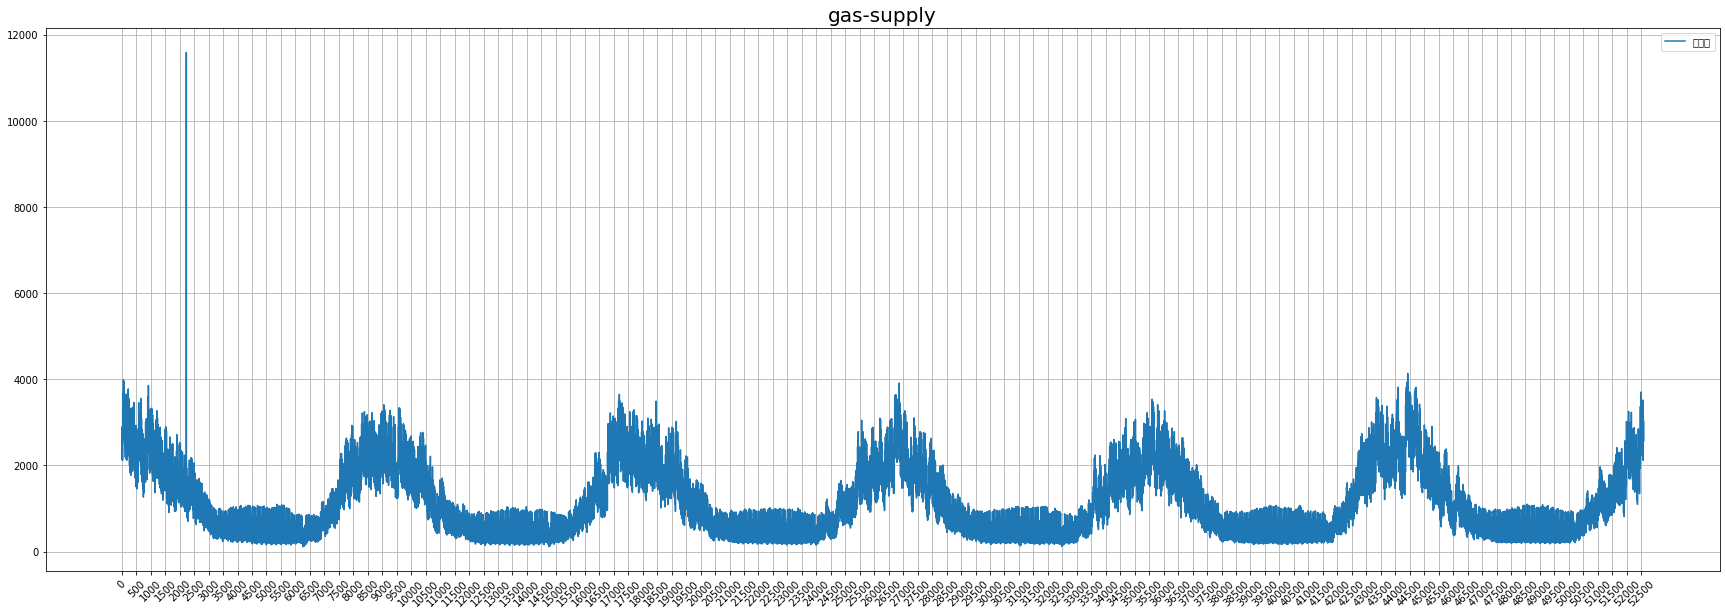

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



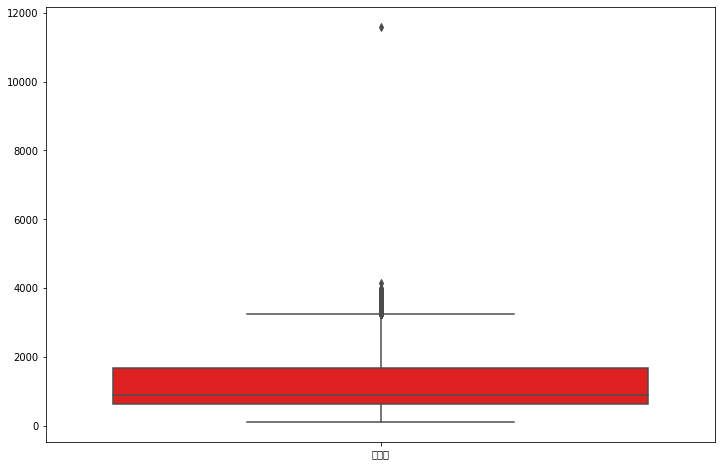

B


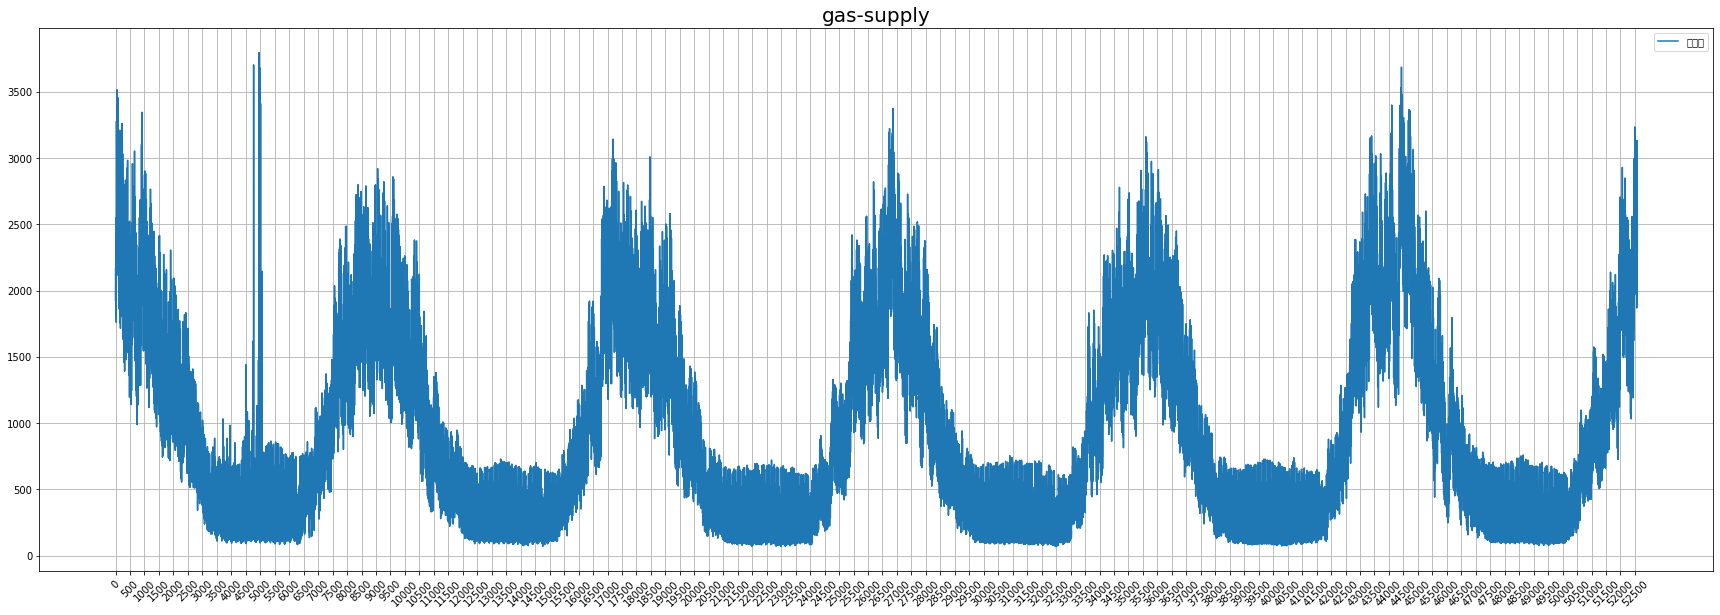

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



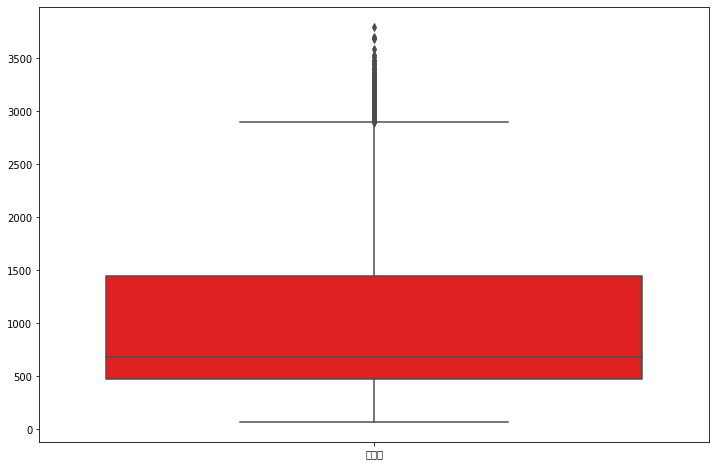

C


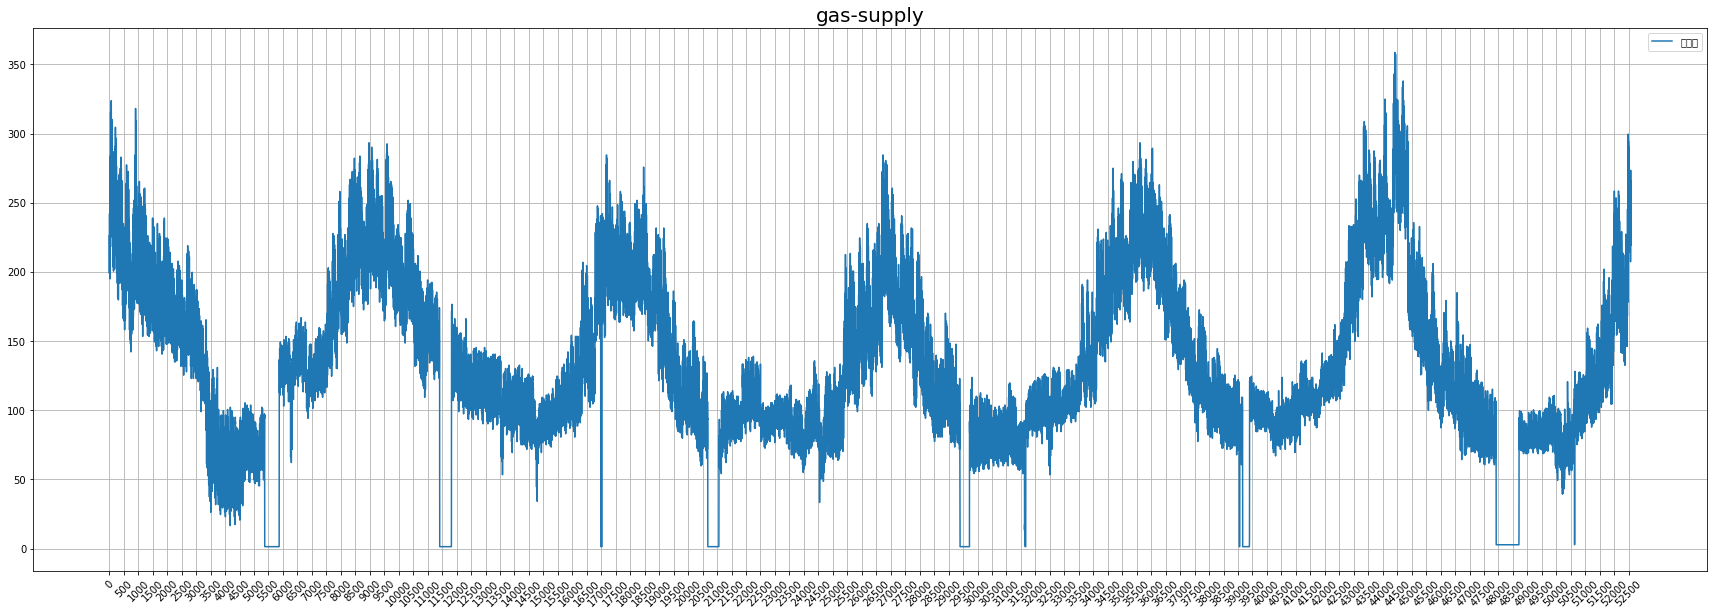

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



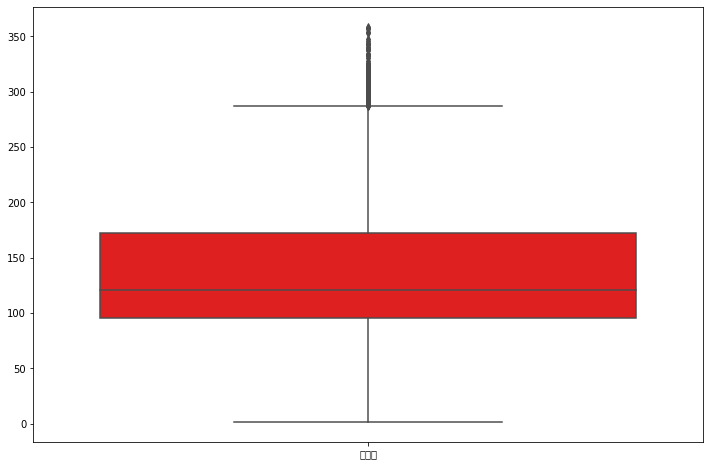

D


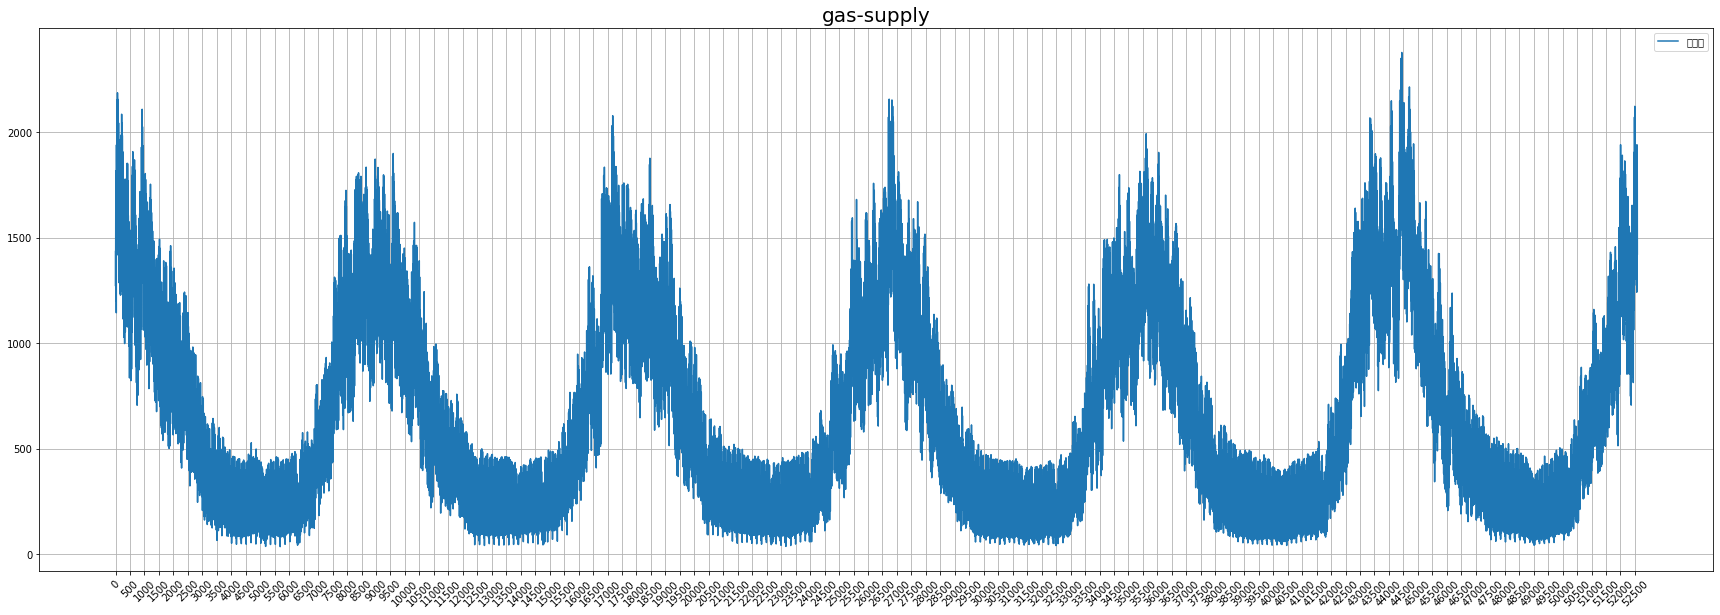

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



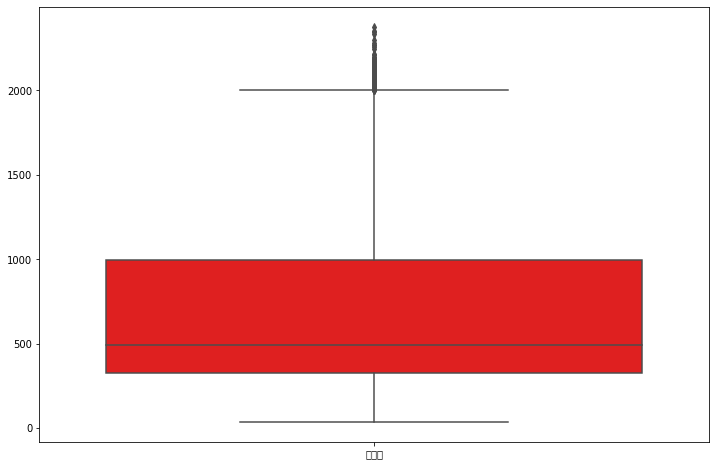

E


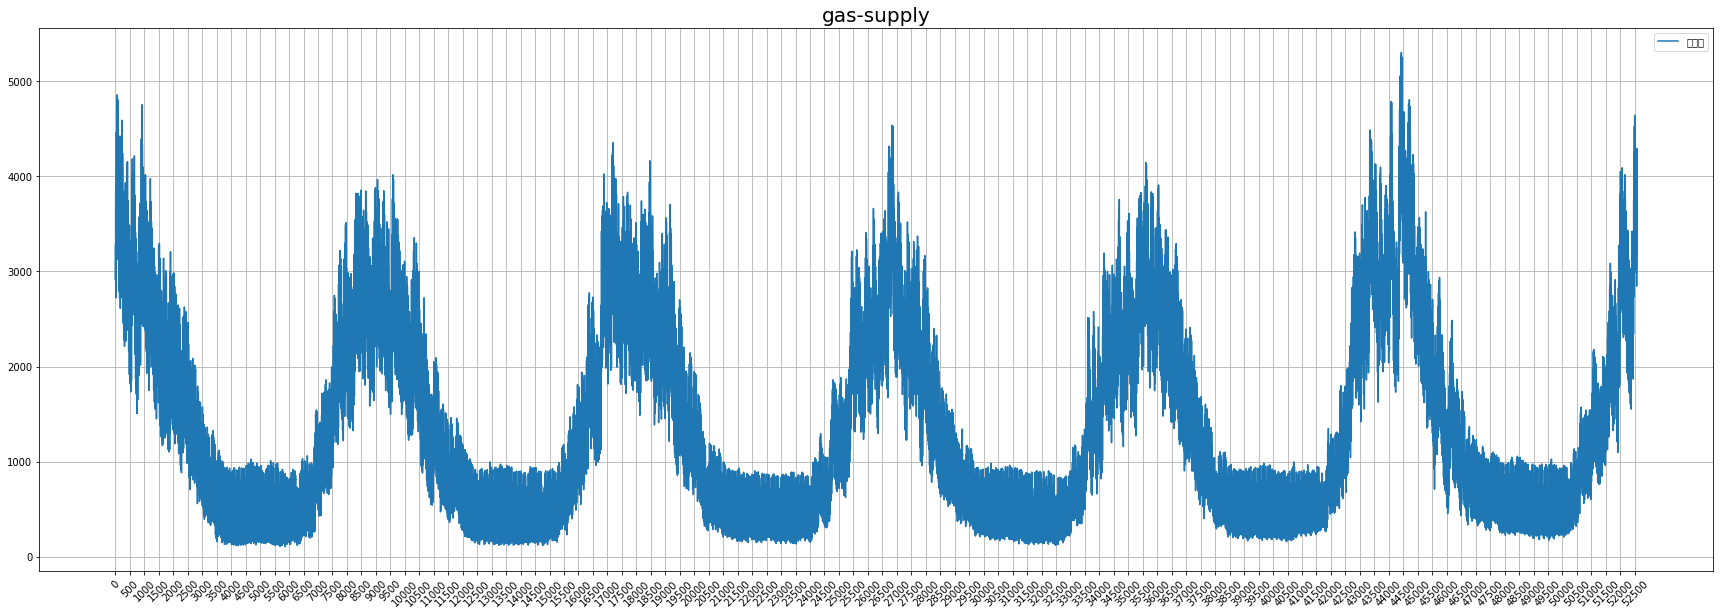

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



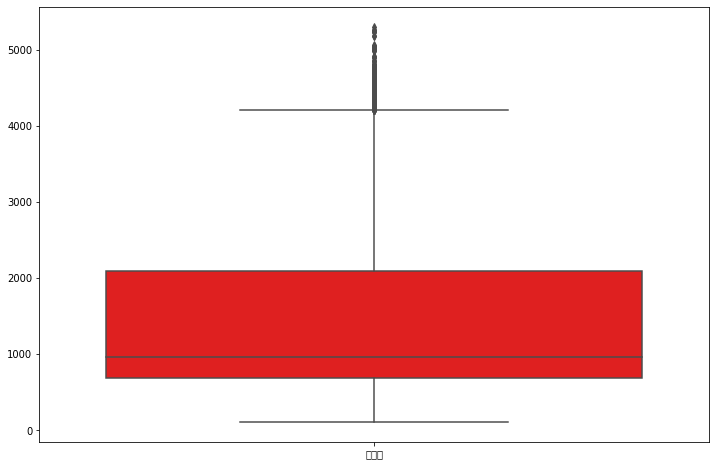

G


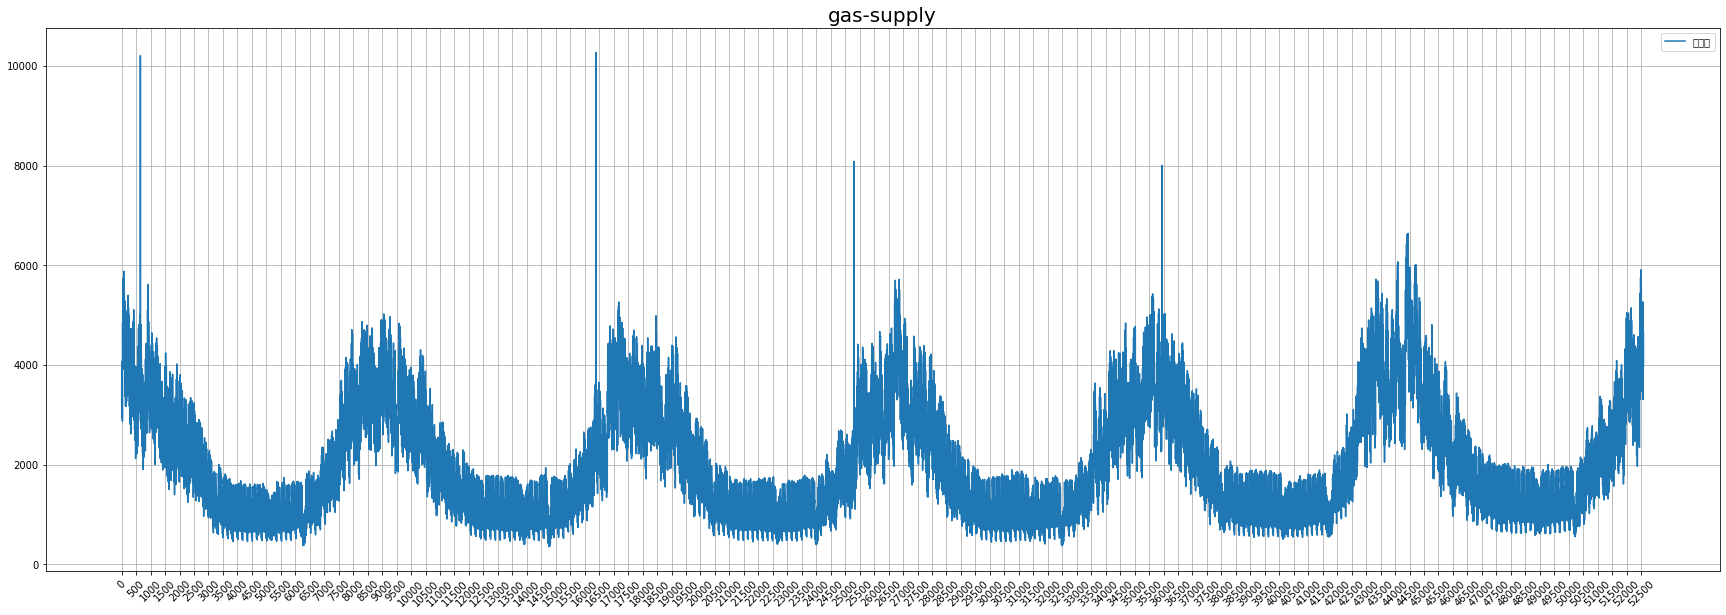

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



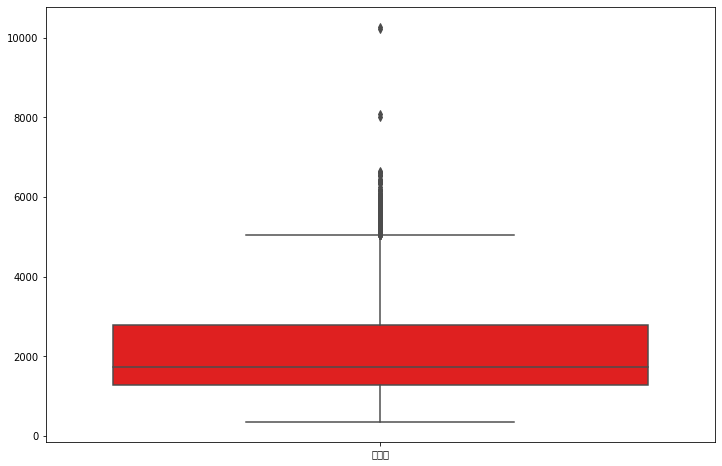

H


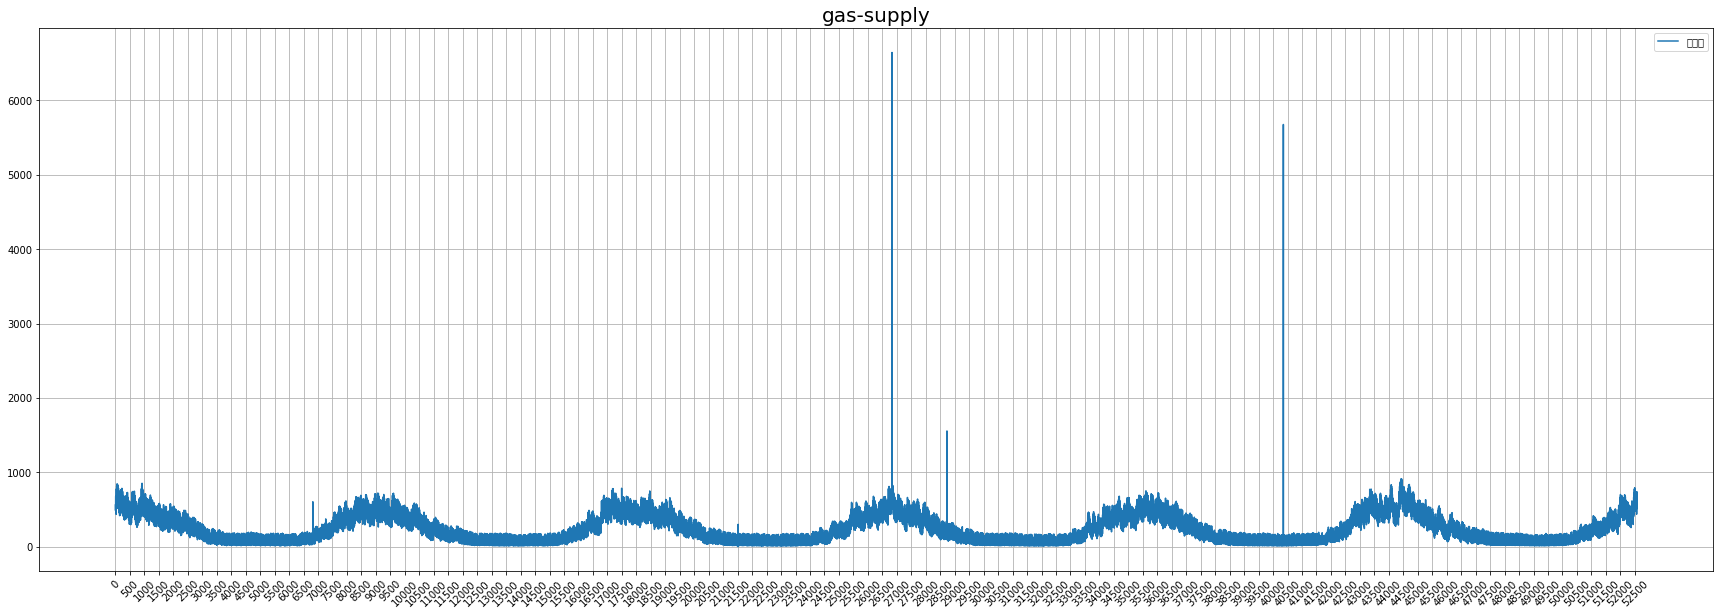

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



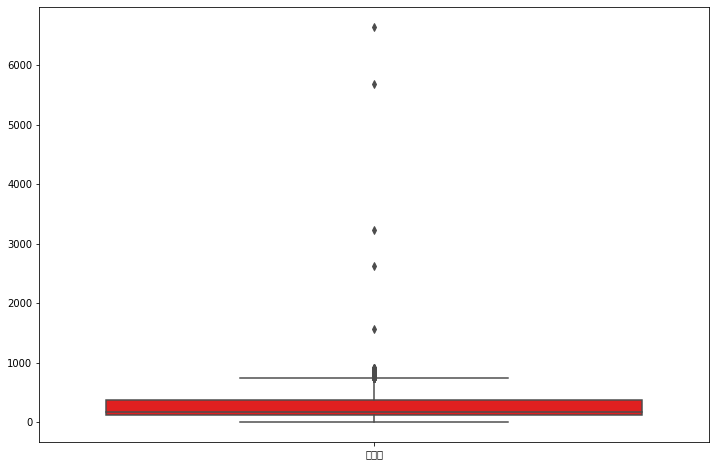

In [ ]:
for t in L:
    print(t)
    df_to_line_graph(df_train_dict[t][["공급량"]])

# 전처리(train)

In [ ]:
# # 양쪽과 50% 차이나는것 골라내기 
# diff=0.5
# for t in L:
#     print(t)
#     size = len(df_dict_prophet[t])

#     removeL=[]

#     for i in range(1,size-1):
#         a=abs(df_dict_prophet[t]["y"].iloc[i]-df_dict_prophet[t]["y"].iloc[i-1])
#         b=abs(df_dict_prophet[t]["y"].iloc[i]-df_dict_prophet[t]["y"].iloc[i+1])

#         if (a/df_dict_prophet[t]["y"].iloc[i]>diff) and (b/df_dict_prophet[t]["y"].iloc[i]>diff):
#             removeL.append(i)
            
#     print(len(removeL))
#     for remove_index in removeL:
#         df_dict_prophet[t]["y"][remove_index]=None

def remove_outlier(now_df_dict,colName,outlier):
    # df의 colName 컬럼값의 outlier를 없앤다
    for t in L:
        for k in outlier[t]:
            a,b = map(int,k.split(":"))
            bound,f=outlier[t][k]
            for i in range(a,b):
                if f=="up":
                    if now_df_dict[t][colName][i]>bound:
                        now_df_dict[t][colName][i]=None
                elif f=="down":
                    if now_df_dict[t][colName][i]<bound:
                        now_df_dict[t][colName][i]=None

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A


,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105
...,...,...,...,...
52579,2018-12-31,20,A,3040.868
52580,2018-12-31,21,A,2973.577
52581,2018-12-31,22,A,2840.272
52582,2018-12-31,23,A,2692.385


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



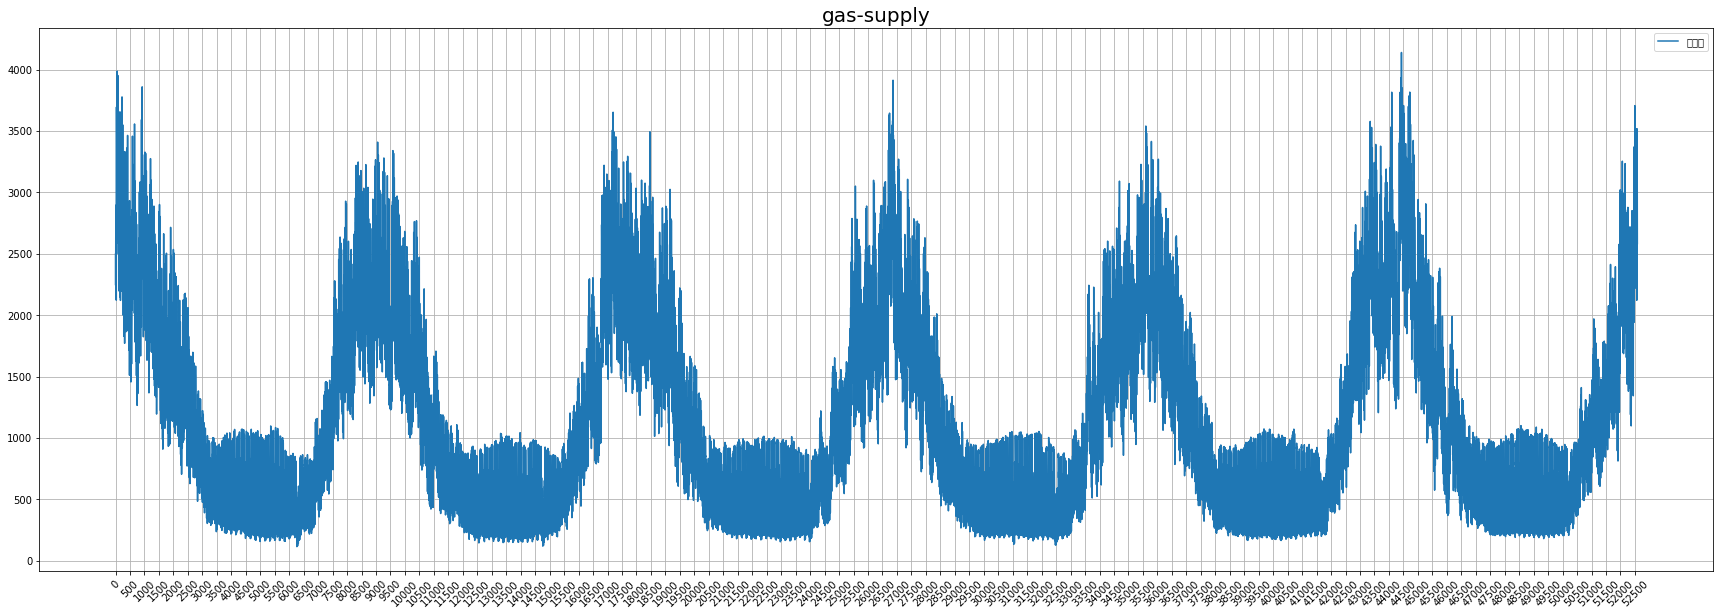

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



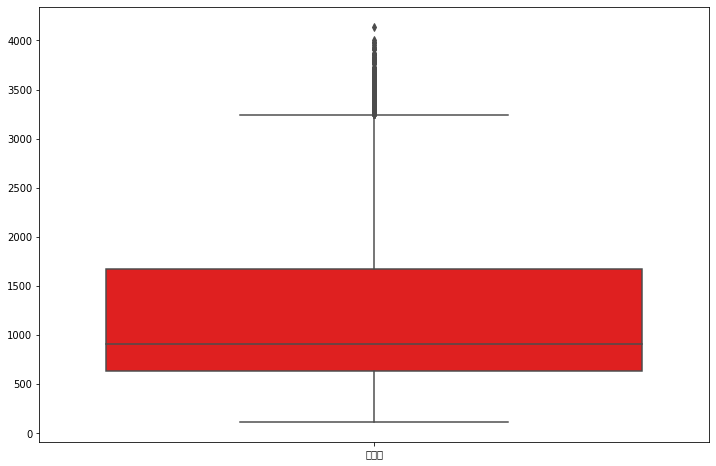

B


,연월일,시간,구분,공급량
0,2013-01-01,1,B,2169.093
1,2013-01-01,2,B,2051.733
2,2013-01-01,3,B,1923.253
3,2013-01-01,4,B,1927.253
4,2013-01-01,5,B,2047.333
...,...,...,...,...
52579,2018-12-31,20,B,2668.688
52580,2018-12-31,21,B,2606.681
52581,2018-12-31,22,B,2540.169
52582,2018-12-31,23,B,2407.945


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



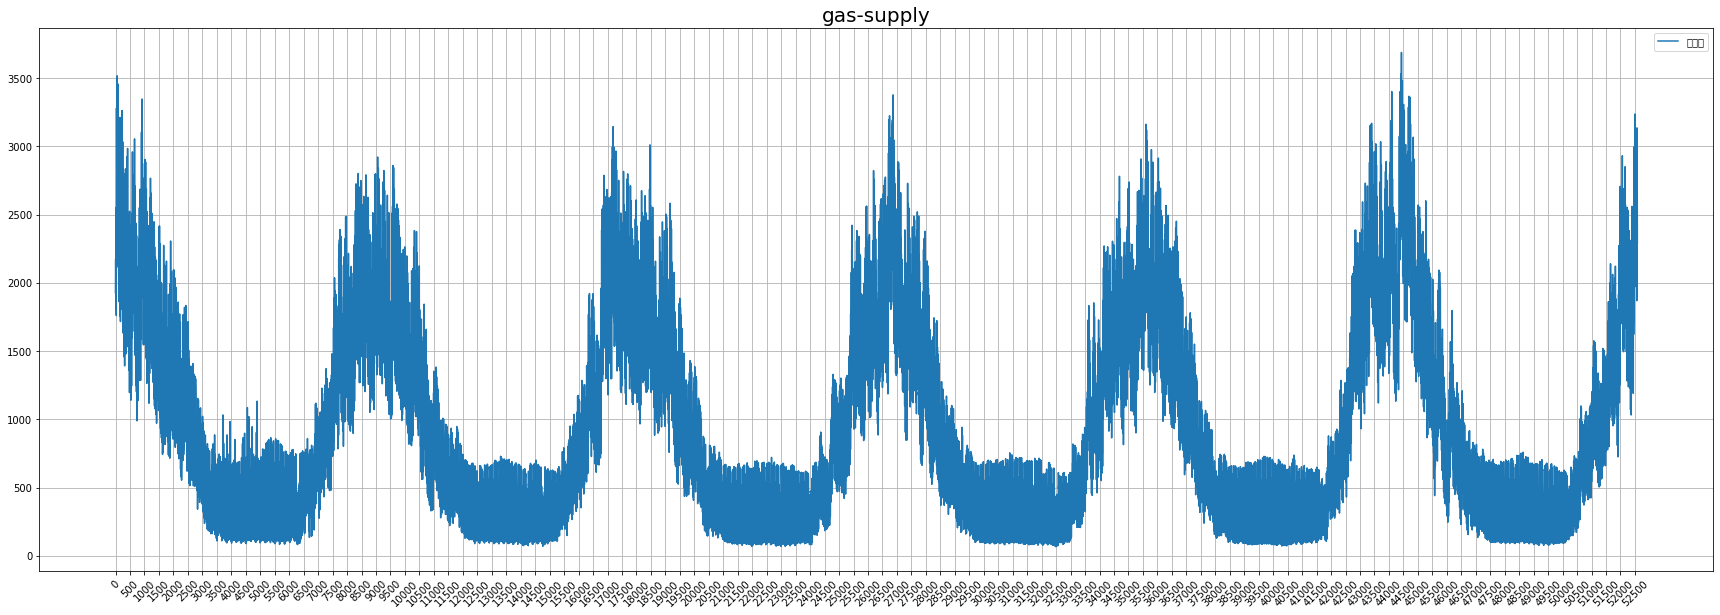

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



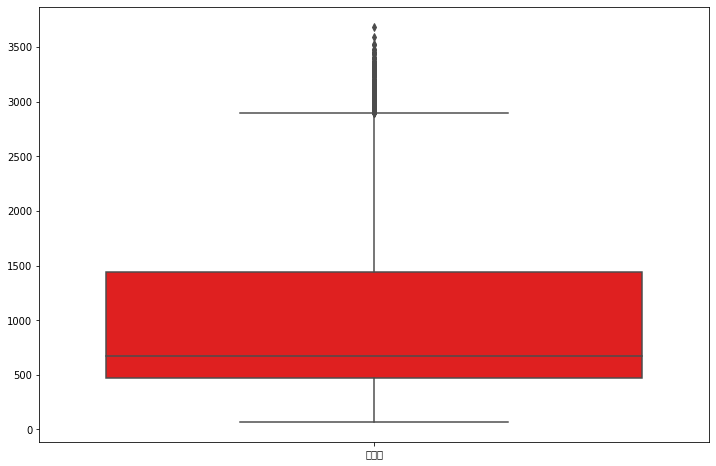

C


,연월일,시간,구분,공급량
0,2013-01-01,1,C,226.178
1,2013-01-01,2,C,215.778
2,2013-01-01,3,C,202.178
3,2013-01-01,4,C,198.978
4,2013-01-01,5,C,200.578
...,...,...,...,...
52579,2018-12-31,20,C,265.980
52580,2018-12-31,21,C,262.239
52581,2018-12-31,22,C,256.000
52582,2018-12-31,23,C,246.020


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



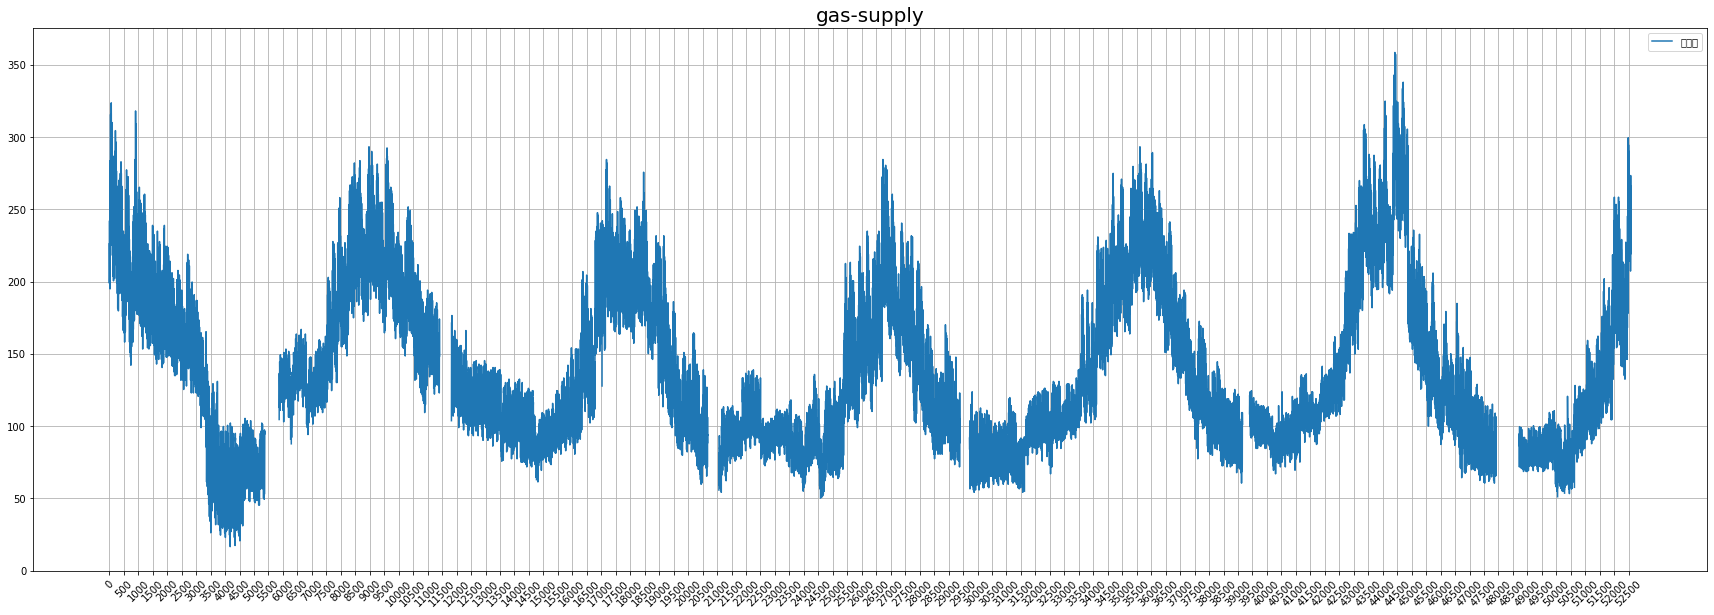

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



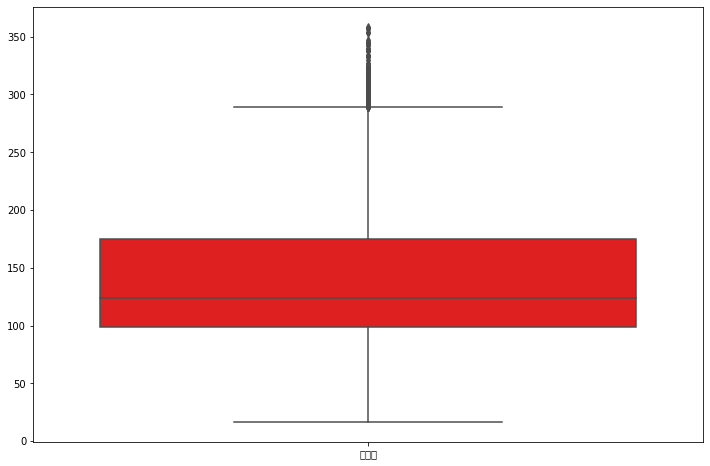

D


,연월일,시간,구분,공급량
0,2013-01-01,1,D,1434.516
1,2013-01-01,2,D,1345.636
2,2013-01-01,3,D,1270.756
3,2013-01-01,4,D,1322.036
4,2013-01-01,5,D,1421.956
...,...,...,...,...
52579,2018-12-31,20,D,1835.411
52580,2018-12-31,21,D,1767.964
52581,2018-12-31,22,D,1720.595
52582,2018-12-31,23,D,1624.138


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



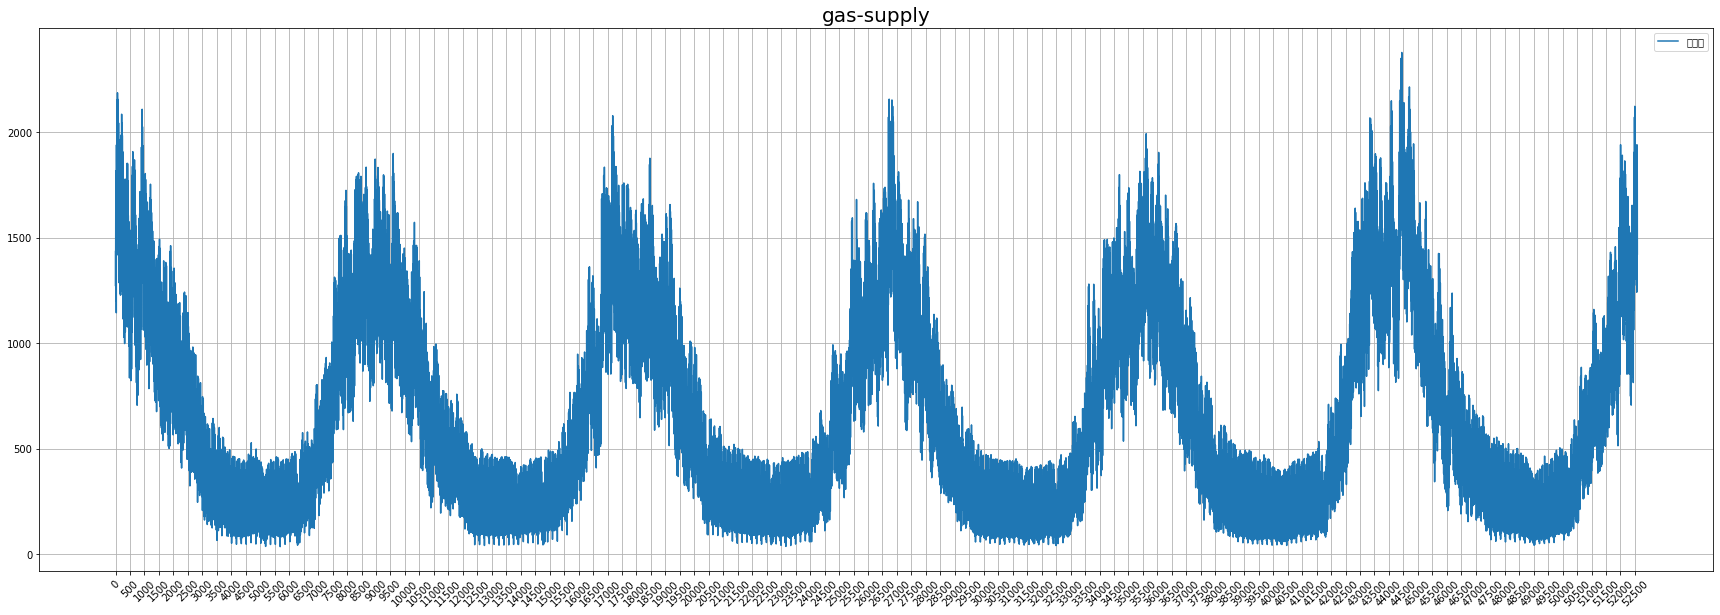

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



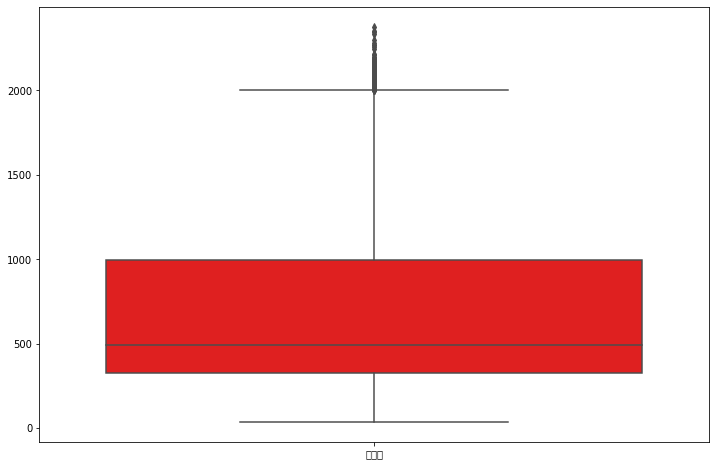

E


,연월일,시간,구분,공급량
0,2013-01-01,1,E,3272.837
1,2013-01-01,2,E,3057.125
2,2013-01-01,3,E,2907.765
3,2013-01-01,4,E,2930.789
4,2013-01-01,5,E,3067.805
...,...,...,...,...
52579,2018-12-31,20,E,4074.485
52580,2018-12-31,21,E,4037.720
52581,2018-12-31,22,E,3954.210
52582,2018-12-31,23,E,3745.844


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



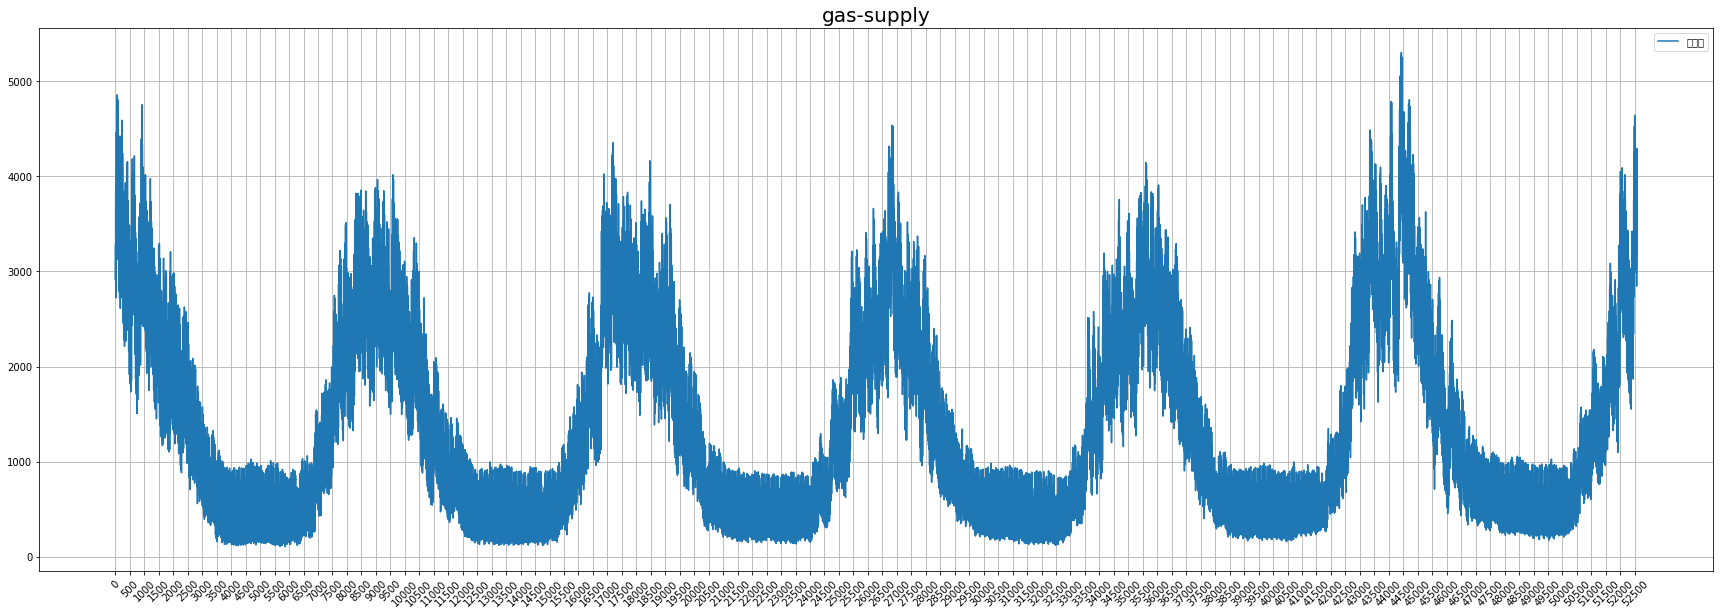

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



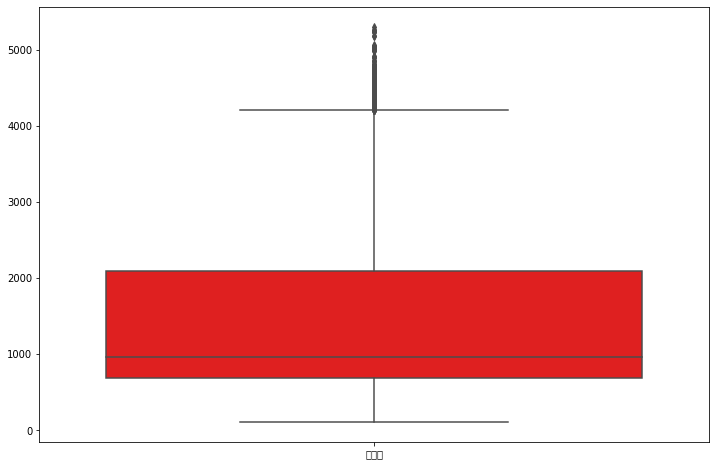

G


,연월일,시간,구분,공급량
0,2013-01-01,1,G,3560.365
1,2013-01-01,2,G,3354.245
2,2013-01-01,3,G,3115.757
3,2013-01-01,4,G,3034.237
4,2013-01-01,5,G,3050.469
...,...,...,...,...
52579,2018-12-31,20,G,4657.562
52580,2018-12-31,21,G,4486.845
52581,2018-12-31,22,G,4354.915
52582,2018-12-31,23,G,4204.484


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



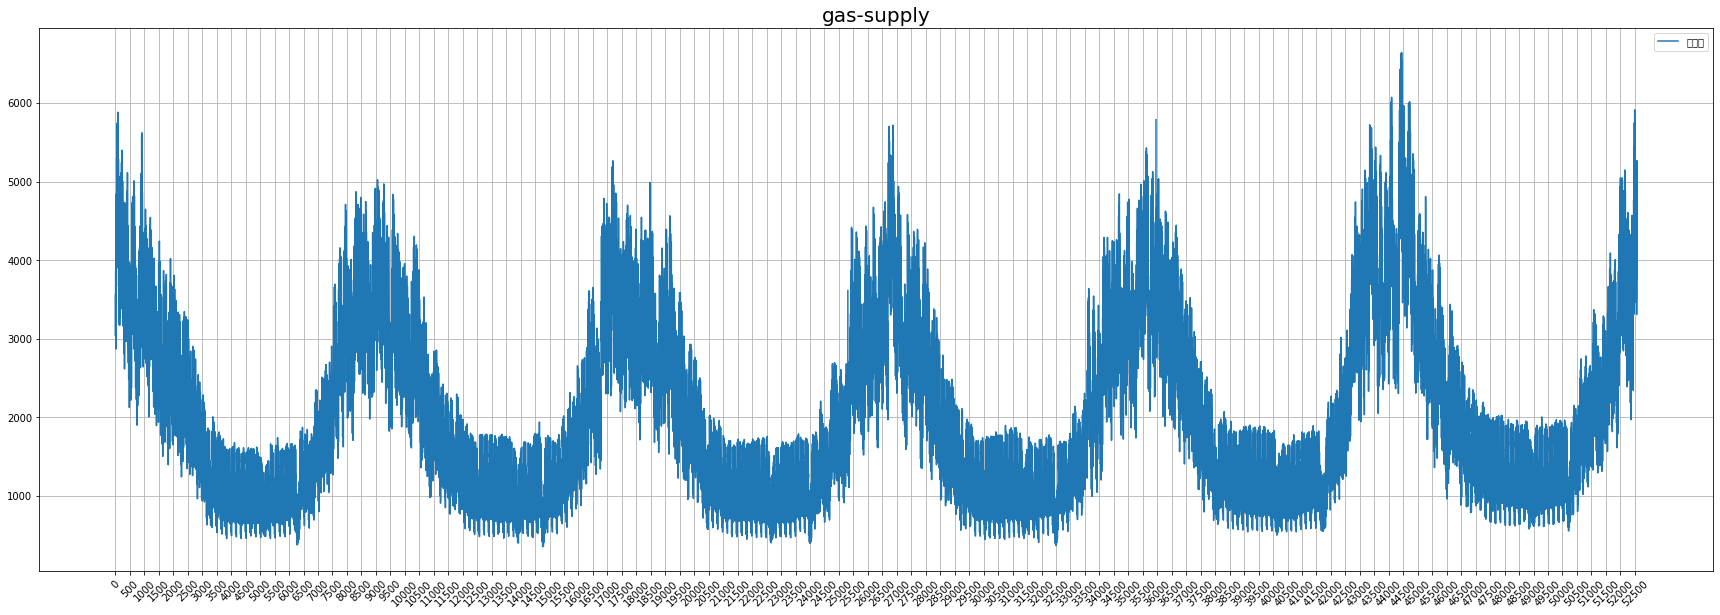

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



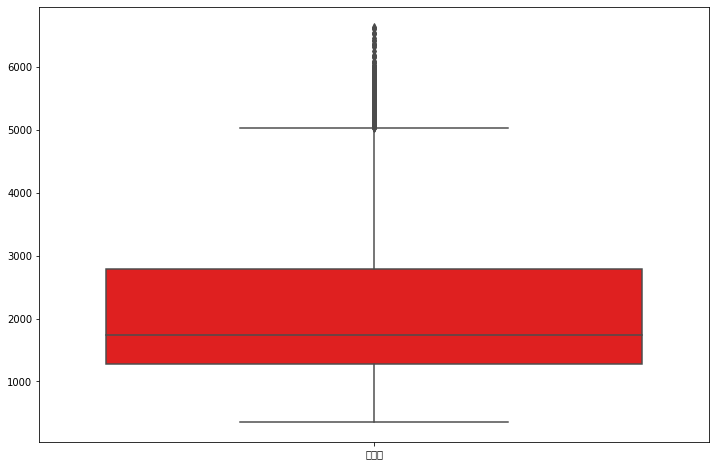

H


,연월일,시간,구분,공급량
0,2013-01-01,1,H,562.964
1,2013-01-01,2,H,531.228
2,2013-01-01,3,H,496.276
3,2013-01-01,4,H,489.396
4,2013-01-01,5,H,535.420
...,...,...,...,...
52579,2018-12-31,20,H,681.033
52580,2018-12-31,21,H,669.961
52581,2018-12-31,22,H,657.941
52582,2018-12-31,23,H,610.953


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



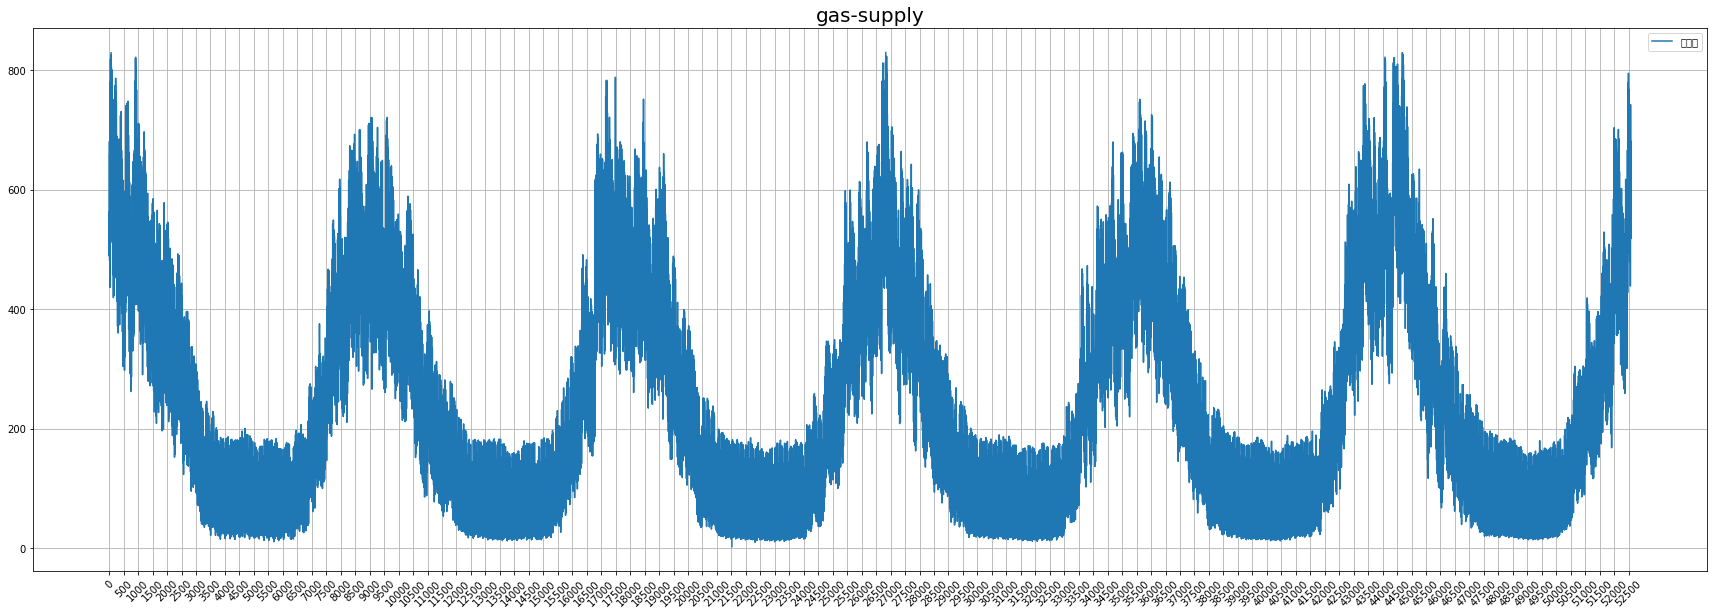

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



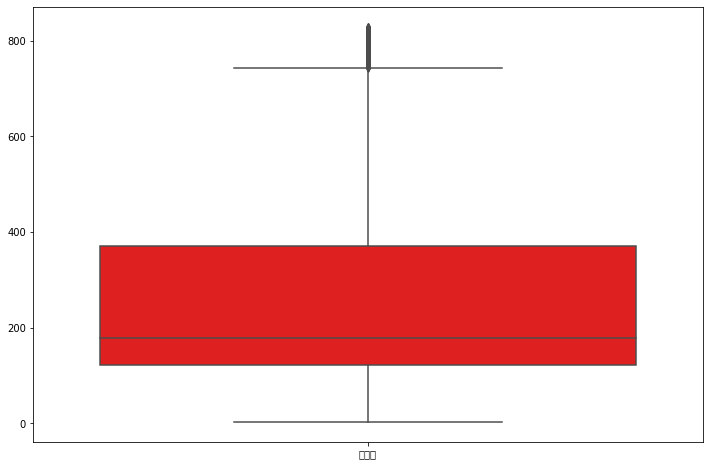

In [ ]:
# 이상치 제거
outlier = {"A":{"2000:2500":[10000,"up"]},
            "B":{"4000:5500":[1250,"up"]},
            "C":{"0:52500":[10,"down"],"14500:52500":[50,"down"],"16500:17500":[100,"down"],"6000:6500":[75,"down"],"13500:14000":[75,"down"],
                    "14500:15000":[60,"down"],"32000:33000":[65,"down"]},
            "D":{},
            "E":{},
            "G":{"0:52500":[7000,"up"]},
            "H":{"0:52500":[830,"up"],"6500:7000":[600,"up"],"21000:22000":[200,"up"]}}

remove_outlier(df_train_dict,"공급량",outlier)
        
# 결측치화 된것 확인 
for t in L:
    print(t)
    display(df_train_dict[t])
    df_to_line_graph(df_train_dict[t][["공급량"]])

In [ ]:
def train_transform_per(now_df_dict):
    df_dict_train_x={}
    df_dict_train_y={}

    # train_x
    dict_x = {"month":[],"day":[],"hour":[]}

    df_for_x = now_df_dict["A"].iloc[:,:2].copy()

    for i in range(train_size_per):
        m = int(df_for_x["연월일"][i][5:7])
        d = int(df_for_x["연월일"][i][-2:])
        h = int(df_for_x["시간"][i])
        
        dict_x["month"].append(m)
        dict_x["day"].append(d)
        dict_x["hour"].append(h)
    
    
    df_train_x = pd.DataFrame({k:dict_x[k] for k in dict_x})
    
    for a in L:
        df_dict_train_x[a] = df_train_x.copy()

    # train_y
    for a in L:
        df_dict_train_y[a] = now_df_dict[a][["공급량"]].rename(columns={"공급량":"y"})
    
    display(df_dict_train_x["A"])
    display(df_dict_train_y["A"])
    return df_dict_train_x, df_dict_train_y
    
def train_transform_full(input_df_dict):
    # x
    now_df_x = pd.DataFrame()
    month_list=[]
    day_list=[]
    hour_list=[]
    type_list=[]
    
    # y
    now_df_y = pd.DataFrame()
    y_list = []

    for a in L:
        temp_df = input_df_dict[a].copy()
        for i in range(train_size_per):
            month_list.append(temp_df["연월일"][i][5:7])
            day_list.append(temp_df["연월일"][i][-2:])
            hour_list.append(temp_df["시간"][i])
            type_list.append(a_to_num[a])

            y_list.append(temp_df["공급량"][i])

    now_df_x["month"] = month_list        
    now_df_x["day"] = day_list
    now_df_x["hour"] = hour_list
    now_df_x["type"] = type_list

    now_df_y["y"] = y_list

    return now_df_x, now_df_y

df_dict_train_x, df_dict_train_y = train_transform_per(df_train_dict)
df_full_train_x, df_full_train_y = train_transform_full(df_train_dict)

,month,day,hour
0,1,1,1
1,1,1,2
2,1,1,3
3,1,1,4
4,1,1,5
...,...,...,...
52579,12,31,20
52580,12,31,21
52581,12,31,22
52582,12,31,23


,y
0,2497.129
1,2363.265
2,2258.505
3,2243.969
4,2344.105
...,...
52579,3040.868
52580,2973.577
52581,2840.272
52582,2692.385


In [ ]:
def make_scaling_func(df):
    col_names = df.columns
    # df을 인풋으로 받아 scaler와 scaled된 df를 반환한다.
    scaler = MinMaxScaler() # standard 스캐일링
    scaler_fit = scaler.fit(df)
    scaled_data = scaler_fit.transform(df)
    scaled_df=pd.DataFrame(scaled_data,columns=col_names)

    # display(scaler, scaled_df)
    return [scaler,scaler_fit], scaled_df

# 생산소별 
df_dict_train_x_scaled={}
df_dict_train_y_scaled={}
scaler_dict_train_x = {}
scaler_dict_train_y = {}

for a in L:
    scaler_dict_train_x[a], df_dict_train_x_scaled[a] = make_scaling_func(df_dict_train_x[a]) # train_x
    scaler_dict_train_y[a], df_dict_train_y_scaled[a] = make_scaling_func(df_dict_train_y[a]) # train_y

display(df_dict_train_x_scaled["A"])
display(df_dict_train_y_scaled["A"])

# 합계 
scaler_full_x, df_full_train_x_scaled = make_scaling_func(df_full_train_x)
scaler_full_y, df_full_train_y_scaled = make_scaling_func(df_full_train_y)

,month,day,hour
0,0.0,0.0,0.000000
1,0.0,0.0,0.043478
2,0.0,0.0,0.086957
3,0.0,0.0,0.130435
4,0.0,0.0,0.173913
...,...,...,...
52579,1.0,1.0,0.826087
52580,1.0,1.0,0.869565
52581,1.0,1.0,0.913043
52582,1.0,1.0,0.956522


,y
0,0.591972
1,0.558718
2,0.532695
3,0.529084
4,0.553959
...,...
52579,0.727042
52580,0.710327
52581,0.677212
52582,0.640475


# 전처리(test)

In [ ]:
def test_transform_per():
    # 생산소별 테스트 x만들기
    df_dict_test_x={}
    for a in L:
        month_list=[]
        day_list=[]
        hour_list=[]
        # type_list=[]

        for i in range(test_size_per):
            my_d = df_test["일자|시간|구분"][i]

            my_month = my_d[5:7]
            my_day = my_d[8:10]
            my_hour = my_d[11:13]

            month_list.append(int(my_month))
            day_list.append(int(my_day))
            hour_list.append(int(my_hour))
            # type_list.append(a_to_num[a])

        
        df_temp_per = pd.DataFrame({"month":month_list, "day":day_list, "hour":hour_list})

        df_dict_test_x[a]=df_temp_per.copy()
    return df_dict_test_x

def test_transform_full():
    # 모든데이터 한번에 학습
    # 생산소는 따로 컬럼으로 표시
    
    month_list=[]
    day_list=[]
    hour_list=[]
    type_list=[]

    for i in range(test_size):
        my_d = df_test["일자|시간|구분"][i]
        my_type=df_test["일자|시간|구분"][i][-1]

        my_month = my_d[5:7]
        my_day = my_d[8:10]
        my_hour = my_d[11:13]

        month_list.append(int(my_month))
        day_list.append(int(my_day))
        hour_list.append(int(my_hour))
        type_list.append(a_to_num[my_type])

    df_temp_full = pd.DataFrame({"month":month_list, "day":day_list, "hour":hour_list, "type":type_list})
    return df_temp_full

In [ ]:
# 생산소별로 test셋 만듦
df_dict_test_x = test_transform_per() 

df_dict_test_x_scaled = {}
for a in L:
    col_names = df_dict_test_x[a].columns
    scaler_fit = scaler_dict_train_x[a][1]
    scaled_data = scaler_fit.transform(df_dict_test_x[a])

    df_dict_test_x_scaled[a] = pd.DataFrame(scaled_data,columns=col_names)

# 모든생산소 test셋 만듦
df_full_test_x = test_transform_full() 
col_names = df_full_test_x.columns
scaeld_data_full = scaler_full_x[1].transform(df_full_test_x)

df_full_test_x_scaled = pd.DataFrame(scaeld_data_full,columns=col_names)
display(df_full_test_x_scaled)

,month,day,hour,type
0,0.000000,0.0,0.000000,0.0
1,0.000000,0.0,0.043478,0.0
2,0.000000,0.0,0.086957,0.0
3,0.000000,0.0,0.130435,0.0
4,0.000000,0.0,0.173913,0.0
...,...,...,...,...
15115,0.181818,1.0,0.826087,1.0
15116,0.181818,1.0,0.869565,1.0
15117,0.181818,1.0,0.913043,1.0
15118,0.181818,1.0,0.956522,1.0


In [ ]:
display(df_dict_train_x_scaled["A"])
display(df_dict_train_y_scaled["A"])
display(df_dict_test_x_scaled["A"])
display(scaler_dict_train_x)

display(df_full_train_x_scaled)
display(df_full_train_y_scaled)
display(df_full_test_x_scaled)

,month,day,hour
0,0.0,0.0,0.000000
1,0.0,0.0,0.043478
2,0.0,0.0,0.086957
3,0.0,0.0,0.130435
4,0.0,0.0,0.173913
...,...,...,...
52579,1.0,1.0,0.826087
52580,1.0,1.0,0.869565
52581,1.0,1.0,0.913043
52582,1.0,1.0,0.956522


,y
0,0.591972
1,0.558718
2,0.532695
3,0.529084
4,0.553959
...,...
52579,0.727042
52580,0.710327
52581,0.677212
52582,0.640475


,month,day,hour
0,0.000000,0.0,0.000000
1,0.000000,0.0,0.043478
2,0.000000,0.0,0.086957
3,0.000000,0.0,0.130435
4,0.000000,0.0,0.173913
...,...,...,...
2155,0.181818,1.0,0.826087
2156,0.181818,1.0,0.869565
2157,0.181818,1.0,0.913043
2158,0.181818,1.0,0.956522


{'A': [MinMaxScaler(), MinMaxScaler()],
 'B': [MinMaxScaler(), MinMaxScaler()],
 'C': [MinMaxScaler(), MinMaxScaler()],
 'D': [MinMaxScaler(), MinMaxScaler()],
 'E': [MinMaxScaler(), MinMaxScaler()],
 'G': [MinMaxScaler(), MinMaxScaler()],
 'H': [MinMaxScaler(), MinMaxScaler()]}

,month,day,hour,type
0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.043478,0.0
2,0.0,0.0,0.086957,0.0
3,0.0,0.0,0.130435,0.0
4,0.0,0.0,0.173913,0.0
...,...,...,...,...
368083,1.0,1.0,0.826087,1.0
368084,1.0,1.0,0.869565,1.0
368085,1.0,1.0,0.913043,1.0
368086,1.0,1.0,0.956522,1.0


,y
0,0.375722
1,0.355558
2,0.339778
3,0.337589
4,0.352672
...,...
368083,0.102167
368084,0.100500
368085,0.098689
368086,0.091611


,month,day,hour,type
0,0.000000,0.0,0.000000,0.0
1,0.000000,0.0,0.043478,0.0
2,0.000000,0.0,0.086957,0.0
3,0.000000,0.0,0.130435,0.0
4,0.000000,0.0,0.173913,0.0
...,...,...,...,...
15115,0.181818,1.0,0.826087,1.0
15116,0.181818,1.0,0.869565,1.0
15117,0.181818,1.0,0.913043,1.0
15118,0.181818,1.0,0.956522,1.0


# 보간

In [ ]:
# # sample
# x=[1,2,3,5,7]
# y=[2,5,8,13,15]

# new_x=[1,2,3,4,5,6,7]
# f_linear = interpolate.interp1d(x, y, kind='linear')

# y_new_linear = f_linear(new_x)
# print(y_new_linear)
# plt.plot(x, y, "o", new_x, y_new_linear, 'x')
# plt.show()

In [ ]:
def df_prophet_to_scatter(df):
    size=len(df)
    rc('font', family='AppleGothic')
    plt.rcParams['axes.unicode_minus'] = False

    cols=df.columns

    fig = plt.figure(figsize=(30, 10)) ## 캔버스 생성
    fig.set_facecolor('white') ## 캔버스 색상 설정
    ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성

    plt.plot(df["ds"], df["y"], 'o') ## 선그래프 생성    
    plt.legend(["y"])
        
    # plt.axis([x최소, x최대, y축최소, y축최대])

    plt.xticks(rotation=45) ## x축 눈금 라벨 설정 - 40도 회전 
    # plt.xticks(np.arange(0, size, 500))
    plt.grid(True)

    plt.title('gas-supply',fontsize=20) ## 타이틀 설정
    plt.show()

    plt.figure(figsize=(12,8))
    sns.boxplot(data=df,color="red")
    plt.show()

df_dict_prophet_interpolated=dict()

for alpha in L:
    print(alpha)
    dict_size=len(df_dict_prophet[alpha])

    # null없는 값으로 x,y생성
    x=list(df_dict_prophet[alpha].loc[df_dict_prophet[alpha]["y"].isna() == False].index)
    y=list(df_dict_prophet[alpha].loc[df_dict_prophet[alpha]["y"].isna() == False]["y"]) 

    #kind = linear(선형),cubic,nearest(가장가까운),next(이후),quadratic
    f_interpolate = interpolate.interp1d(x, y, kind='linear')

    # null있는값으로 바꿔서 보간
    new_x=list(df_dict_prophet[alpha]["y"].index)
    new_y=f_interpolate(new_x)

    df = df_dict_prophet[alpha].copy()
    df["y"]=new_y

    df_dict_prophet_interpolated[alpha]=df.copy()

# for alpha in L:
#     alpha="C"
#     dict_size=len(df_dict_prophet[alpha])

#     # null없는 값으로 x,y생성
#     x=list(df_dict_prophet[alpha].loc[df_dict_prophet[alpha]["y"].isna() == False].index)
#     y=list(df_dict_prophet[alpha].loc[df_dict_prophet[alpha]["y"].isna() == False]["y"]) 
#     new_x=list(df_dict_prophet[alpha]["y"].index)

#     my_spl = splrep(x,y,s=3) # 그래프 만들기
#     # print(my_spl[0])
#     # print(my_spl[1])
#     # print(my_spl[2])
#     new_y = splev(new_x, my_spl) # 그래프의 x에 해당하는 y점 찾기 

#     # 스탑!
#     df = df_dict_prophet[alpha].copy()
#     df["y"]=new_y

#     df_dict_prophet_interpolated[alpha]=df.copy()
#     break

for alpha in L:
    print(alpha)
    df_prophet_to_scatter(df_dict_prophet_interpolated[alpha])

A


NameError: ignored

# train, predict

In [ ]:
# 결측치 제거(거래소별)
df_dict_train_x_scaled_remove_none = {}
df_dict_train_y_scaled_remove_none = {}
for a in L:
    now_df_x = df_dict_train_x_scaled[a].copy()
    now_df_y = df_dict_train_y_scaled[a].copy()

    for i,value in enumerate(list(now_df_y["y"].isnull())):
        if value:
            now_df_x["month"][i]=None

    now_df_x.dropna(inplace=True)
    now_df_y.dropna(inplace=True)

    df_dict_train_x_scaled_remove_none[a]=now_df_x
    df_dict_train_y_scaled_remove_none[a]=now_df_y

# 결측치 제거(거래소별)
df_full_train_x_scaled_remove_none = df_full_train_x_scaled.copy()
df_full_train_y_scaled_remove_none = df_full_train_y_scaled.copy()

for i,value in enumerate(list(df_full_train_y_scaled_remove_none["y"].isnull())):
    if value:
        df_full_train_x_scaled_remove_none["month"][i]=None

df_full_train_x_scaled_remove_none.dropna(inplace=True)
df_full_train_y_scaled_remove_none.dropna(inplace=True)

display(len(df_full_train_x_scaled_remove_none))
display(len(df_full_train_y_scaled_remove_none))

365205

365205

In [ ]:
concated_df = pd.concat([df_dict_train_x["A"],df_dict_train_y["A"]],axis=1)

concated_df = concated_df.sample(frac=1)
suffled_x = concated_df.iloc[:,:3] 
display(suffled_x)
suffled_y = concated_df[["y"]]
display(suffled_y)

,month,day,hour
14061,8,9,22
34227,11,27,4
24188,10,5,21
49239,8,14,16
27601,2,25,2
...,...,...,...
21927,7,3,16
32142,9,1,7
33475,10,26,20
31663,8,12,8


,y
14061,399.289
34227,1247.073
24188,731.401
49239,877.185
27601,1641.905
...,...
21927,752.121
32142,540.897
33475,1023.561
31663,792.825


In [ ]:
# 거래소별 학습
for a in L:
    print(a)
    x=df_dict_train_x_scaled_remove_none[a]
    y=df_dict_train_y_scaled_remove_none[a]

    concated_df = pd.concat([x,y],axis=1)
    concated_df = concated_df.sample(frac=1)

    x = concated_df.iloc[:,:3] 
    y = concated_df[["y"]]

    display(x)
    display(y)

    # my_model = DecisionTreeRegressor().fit(x,y)
    # my_model = RandomForestRegressor().fit(x,y)
    # my_model = XGBRegressor().fit(x,y)
    my_model = LGBMRegressor(learning_rate=0.01).fit(x,y)

    predict = my_model.predict(df_dict_test_x[a], pred_contrib=False) 
    
    display(predict)

A


,month,day,hour
1264,0.090909,0.700000,0.695652
9566,0.090909,0.066667,0.608696
42831,0.909091,0.633333,0.652174
36286,0.090909,0.633333,0.956522
5276,0.636364,0.233333,0.869565
...,...,...,...
34411,1.000000,0.100000,0.826087
35864,0.090909,0.066667,0.347826
30643,0.454545,0.966667,0.826087
45127,0.090909,0.766667,0.304348


,y
1264,0.438795
9566,0.515787
42831,0.438018
36286,0.555360
5276,0.137232
...,...
34411,0.406802
35864,0.668309
30643,0.158514
45127,0.429050


array([0.44472161, 0.44472161, 0.44472161, ..., 0.44472161, 0.44472161,
       0.44472161])

B


,month,day,hour
29839,0.363636,0.900000,0.304348
39676,0.545455,0.366667,0.173913
18280,0.090909,0.000000,0.695652
34332,1.000000,0.000000,0.521739
28748,0.272727,0.366667,0.869565
...,...,...,...
16166,0.909091,0.133333,0.608696
11250,0.272727,0.433333,0.782609
39156,0.454545,0.633333,0.521739
48506,0.545455,0.466667,0.086957


,y
29839,0.102989
39676,0.018896
18280,0.410628
34332,0.344956
28748,0.221580
...,...
16166,0.145576
11250,0.173644
39156,0.161643
48506,0.011336


array([0.44804792, 0.44804792, 0.44804792, ..., 0.44804792, 0.44804792,
       0.44804792])

C


,month,day,hour
18883,0.090909,0.833333,0.826087
28970,0.272727,0.700000,0.086957
8198,1.000000,0.233333,0.608696
40606,0.636364,0.600000,0.956522
18251,0.000000,1.000000,0.478261
...,...,...,...
2395,0.272727,0.300000,0.826087
16634,0.909091,0.800000,0.086957
45851,0.181818,0.833333,0.478261
10679,0.181818,0.666667,1.000000


,y
18883,0.612729
28970,0.210480
8198,0.456039
40606,0.210480
18251,0.575311
...,...
2395,0.528538
16634,0.278301
45851,0.325942
10679,0.495796


array([0.51679862, 0.51679862, 0.51679862, ..., 0.51679862, 0.51679862,
       0.51679862])

D


,month,day,hour
17674,0.000000,0.200000,0.434783
13157,0.545455,0.066667,0.217391
32621,0.727273,0.666667,0.217391
5221,0.636364,0.166667,0.565217
34993,1.000000,0.933333,0.043478
...,...,...,...
49606,0.636364,0.933333,0.956522
17435,1.000000,0.900000,0.478261
19990,0.272727,0.400000,0.956522
24167,0.818182,0.100000,1.000000


,y
17674,0.639833
13157,0.063279
32621,0.059613
5221,0.127104
34993,0.406272
...,...
49606,0.075474
17435,0.539824
19990,0.300807
24167,0.093278


array([0.46558932, 0.46558932, 0.46558932, ..., 0.46558932, 0.46558932,
       0.46558932])

E


,month,day,hour
27766,0.181818,0.033333,0.956522
31345,0.545455,0.966667,0.043478
5426,0.636364,0.466667,0.086957
50811,0.818182,0.600000,0.130435
40607,0.636364,0.600000,1.000000
...,...,...,...
2297,0.272727,0.166667,0.739130
4666,0.545455,0.433333,0.434783
46234,0.272727,0.333333,0.434783
19600,0.181818,0.900000,0.695652


,y
27766,0.489070
31345,0.033914
5426,0.009574
50811,0.118021
40607,0.059368
...,...
2297,0.314302
4666,0.137345
46234,0.237817
19600,0.198651


array([0.45252029, 0.45252029, 0.45252029, ..., 0.45252029, 0.45252029,
       0.45252029])

G


,month,day,hour
4244,0.454545,0.833333,0.869565
282,0.000000,0.366667,0.782609
16724,0.909091,0.900000,0.869565
30068,0.454545,0.166667,0.869565
13445,0.545455,0.466667,0.217391
...,...,...,...
45798,0.181818,0.766667,0.260870
24959,0.909091,0.166667,1.000000
32585,0.727273,0.600000,0.739130
23301,0.636364,0.933333,0.913043


,y
4244,0.145635
282,0.580279
16724,0.361443
30068,0.122741
13445,0.078470
...,...
45798,0.336339
24959,0.265558
32585,0.162014
23301,0.090884


array([0.44731728, 0.44731728, 0.44731728, ..., 0.44731728, 0.44731728,
       0.44731728])

H


,month,day,hour
19665,0.181818,1.000000,0.391304
43933,0.000000,0.133333,0.565217
14528,0.636364,0.933333,0.347826
39447,0.545455,0.033333,0.652174
43153,1.000000,0.100000,0.043478
...,...,...,...
42727,0.909091,0.500000,0.304348
24879,0.909091,0.066667,0.652174
50606,0.818182,0.300000,0.608696
30004,0.454545,0.100000,0.173913


,y
19665,0.351011
43933,0.558064
14528,0.178805
39447,0.135652
43153,0.322027
...,...
42727,0.590187
24879,0.170000
50606,0.183881
30004,0.066471


array([0.52430569, 0.52430569, 0.52430569, ..., 0.52430569, 0.52430569,
       0.52430569])

In [ ]:
# 거래소별 학습
for a in L:
    print(a)
    x=df_dict_train_x_scaled_remove_none[a]
    y=df_dict_train_y_scaled_remove_none[a]

    display(x)
    display(y)

    # my_model = DecisionTreeRegressor().fit(x,y)
    # my_model = RandomForestRegressor().fit(x,y)
    # my_model = XGBRegressor().fit(x,y)
    my_model = LGBMRegressor(learning_rate=0.01).fit(x,y)

    predict = my_model.predict(df_dict_test_x[a], pred_contrib=False) 
    
    display(predict)

A


,month,day,hour
0,0.0,0.0,0.000000
1,0.0,0.0,0.043478
2,0.0,0.0,0.086957
3,0.0,0.0,0.130435
4,0.0,0.0,0.173913
...,...,...,...
52579,1.0,1.0,0.826087
52580,1.0,1.0,0.869565
52581,1.0,1.0,0.913043
52582,1.0,1.0,0.956522


,y
0,0.591972
1,0.558718
2,0.532695
3,0.529084
4,0.553959
...,...
52579,0.727042
52580,0.710327
52581,0.677212
52582,0.640475


array([0.44472161, 0.44472161, 0.44472161, ..., 0.44472161, 0.44472161,
       0.44472161])

B


,month,day,hour
0,0.0,0.0,0.000000
1,0.0,0.0,0.043478
2,0.0,0.0,0.086957
3,0.0,0.0,0.130435
4,0.0,0.0,0.173913
...,...,...,...
52579,1.0,1.0,0.826087
52580,1.0,1.0,0.869565
52581,1.0,1.0,0.913043
52582,1.0,1.0,0.956522


,y
0,0.580449
1,0.548027
2,0.512534
3,0.513639
4,0.546812
...,...
52579,0.718465
52580,0.701335
52581,0.682961
52582,0.646433


array([0.44804792, 0.44804792, 0.44804792, ..., 0.44804792, 0.44804792,
       0.44804792])

C


,month,day,hour
0,0.0,0.0,0.000000
1,0.0,0.0,0.043478
2,0.0,0.0,0.086957
3,0.0,0.0,0.130435
4,0.0,0.0,0.173913
...,...,...,...
52579,1.0,1.0,0.826087
52580,1.0,1.0,0.869565
52581,1.0,1.0,0.913043
52582,1.0,1.0,0.956522


,y
0,0.612729
1,0.582327
2,0.542569
3,0.533215
4,0.537892
...,...
52579,0.729084
52580,0.718147
52581,0.699909
52582,0.670734


array([0.51679862, 0.51679862, 0.51679862, ..., 0.51679862, 0.51679862,
       0.51679862])

D


,month,day,hour
0,0.0,0.0,0.000000
1,0.0,0.0,0.043478
2,0.0,0.0,0.086957
3,0.0,0.0,0.130435
4,0.0,0.0,0.173913
...,...,...,...
52579,1.0,1.0,0.826087
52580,1.0,1.0,0.869565
52581,1.0,1.0,0.913043
52582,1.0,1.0,0.956522


,y
0,0.597218
1,0.559258
2,0.527277
3,0.549179
4,0.591854
...,...
52579,0.768439
52580,0.739633
52581,0.719402
52582,0.678205


array([0.46558932, 0.46558932, 0.46558932, ..., 0.46558932, 0.46558932,
       0.46558932])

E


,month,day,hour
0,0.0,0.0,0.000000
1,0.0,0.0,0.043478
2,0.0,0.0,0.086957
3,0.0,0.0,0.130435
4,0.0,0.0,0.173913
...,...,...,...
52579,1.0,1.0,0.826087
52580,1.0,1.0,0.869565
52581,1.0,1.0,0.913043
52582,1.0,1.0,0.956522


,y
0,0.609382
1,0.567846
2,0.539086
3,0.543520
4,0.569903
...,...
52579,0.763743
52580,0.756664
52581,0.740583
52582,0.700462


array([0.45252029, 0.45252029, 0.45252029, ..., 0.45252029, 0.45252029,
       0.45252029])

G


,month,day,hour
0,0.0,0.0,0.000000
1,0.0,0.0,0.043478
2,0.0,0.0,0.086957
3,0.0,0.0,0.130435
4,0.0,0.0,0.173913
...,...,...,...
52579,1.0,1.0,0.826087
52580,1.0,1.0,0.869565
52581,1.0,1.0,0.913043
52582,1.0,1.0,0.956522


,y
0,0.509837
1,0.477048
2,0.439110
3,0.426142
4,0.428724
...,...
52579,0.684377
52580,0.657220
52581,0.636232
52582,0.612302


array([0.44731728, 0.44731728, 0.44731728, ..., 0.44731728, 0.44731728,
       0.44731728])

H


,month,day,hour
0,0.0,0.0,0.000000
1,0.0,0.0,0.043478
2,0.0,0.0,0.086957
3,0.0,0.0,0.130435
4,0.0,0.0,0.173913
...,...,...,...
52579,1.0,1.0,0.826087
52580,1.0,1.0,0.869565
52581,1.0,1.0,0.913043
52582,1.0,1.0,0.956522


,y
0,0.677542
1,0.639159
2,0.596886
3,0.588565
4,0.644229
...,...
52579,0.820340
52580,0.806949
52581,0.792412
52582,0.735582


array([0.52430569, 0.52430569, 0.52430569, ..., 0.52430569, 0.52430569,
       0.52430569])

In [ ]:
# 전체학습
train_x = df_full_train_x_scaled_remove_none
train_y = df_full_train_y_scaled_remove_none
test_x = df_full_test_x_scaled

my_model = LGBMRegressor(learning_rate=0.001,  metric='mae').fit(train_x, train_y)
predict = my_model.predict(df_full_test_x) 
display(predict)

array([0.15806079, 0.15806079, 0.15806079, ..., 0.13523095, 0.13523095,
       0.13523095])

In [ ]:
my_y_hat = list(scaler_full.inverse_transform(np.array(predict).reshape(-1,1)).flatten())
my_y_hat

AttributeError: ignored

In [ ]:
# # 전처리
# def dl_preprocess(alpha, sequence):
#     alpha = alpha

#     data=list(df_dict_prophet_interpolated_scaled[alpha]["y"])
#     sequence=sequence1

#     x=[]
#     y=[]

#     for i in tqdm(range(train_size_per-sequence)):
#         x.append(np.array(data[i:i+sequence]))
#         y.append(np.array(data[i+sequence]))

#     x=np.array(x)
#     y=np.array(y)

#     x=x.reshape(x.shape[0],x.shape[1],1)
#     y=y.reshape(y.shape[0],1)

#     return x,y

# def lstm_func(x_train,y_train,epoch):
#     dropout=0.3
#     batch_size=14
#     verbose=1
#     epoch=epoch

#     # LSTM
#     model = Sequential()
#     model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), activation='relu', return_sequences=True))
#     model.add(Dropout(dropout)) 
#     model.add(LSTM(64, activation="relu", return_sequences=False))
#     model.add(Dropout(dropout)) 
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mean_absolute_error')

#     model_fit = model.fit(x_train, y_train, 
#                             batch_size=batch_size, 
#                             epochs=epoch,
#                             verbose=verbose)

#     # 예측값 순차 적으로 추출
#     now_x=np.concatenate((x[-1][1:],np.array([y[-1]])),axis=0)
#     test_y=[]
#     for i in tqdm(range(test_size_per)):
#         now_y = model.predict(np.array([now_x]))
#         test_y.append(now_y[0][0])
#         now_x=np.concatenate((now_x[1:],now_y),axis=0)
        
#     return test_y

# def reverse_scale(alpha,test_y):
#     # 역정규화 
#     scaler = scaler_dict[alpha]
#     inverse_scaled_data = scaler.inverse_transform(test_y)

#     tempL=list(df_dict_prophet_interpolated[alpha]["y"])
#     tempL.extend(list(inverse_scaled_data))
#     tempDf = pd.DataFrame(tempL)
#     return tempDf

# def df_to_scatter(df):
#     size=len(df)
#     rc('font', family='AppleGothic')
#     plt.rcParams['axes.unicode_minus'] = False

#     cols=df.columns

#     fig = plt.figure(figsize=(30, 10)) ## 캔버스 생성
#     fig.set_facecolor('white') ## 캔버스 색상 설정
#     ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성

#     plt.plot(df[0], 'o') ## 선그래프 생성    
#     plt.legend(["y"])
        
#     # plt.axis([x최소, x최대, y축최소, y축최대])

#     plt.xticks(rotation=45) ## x축 눈금 라벨 설정 - 40도 회전 
#     # plt.xticks(np.arange(0, size, 500))
#     plt.grid(True)

#     plt.title('gas-supply',fontsize=20) ## 타이틀 설정
#     plt.show()

#     plt.figure(figsize=(12,8))
#     sns.boxplot(data=df,color="red")
#     plt.show()

# my_y_hat=[]
# epoch=500
# for alpha in L:
#     if alpha=="A":
#         continue
#     x,y = dl_preprocess(alpha,24)
#     test_y = lstm_func(x,y,epoch)
#     df = reverse_scale(alpha,test_y)

#     with open(path+f"/dl_pickle/{alpha}.pickle",'wb') as fw:
#         pickle.dump(test_y, fw)
    
#     print(df[0].iloc[-test_size_per:])
#     my_y_hat.extend(df[0].iloc[-test_size_per:])
#     df_to_scatter(df)

100%|██████████| 52560/52560 [00:00<00:00, 248945.42it/s]


Epoch 1/500
3755/3755 [==============================] - 145s 38ms/step - loss: 0.1796
Epoch 2/500
3755/3755 [==============================] - 143s 38ms/step - loss: 0.1318
Epoch 3/500
3755/3755 [==============================] - 154s 41ms/step - loss: 0.1203
Epoch 4/500
3755/3755 [==============================] - 143s 38ms/step - loss: 0.1137
Epoch 5/500
3755/3755 [==============================] - 140s 37ms/step - loss: 0.1115
Epoch 6/500
3755/3755 [==============================] - 139s 37ms/step - loss: 0.1079
Epoch 7/500
3755/3755 [==============================] - 139s 37ms/step - loss: 0.1064
Epoch 8/500
3755/3755 [==============================] - 139s 37ms/step - loss: 0.1041
Epoch 9/500
3755/3755 [==============================] - 142s 38ms/step - loss: 0.1033
Epoch 10/500
3755/3755 [==============================] - 141s 38ms/step - loss: 0.1013
Epoch 11/500
3755/3755 [==============================] - 140s 37ms/step - loss: 0.1006
Epoch 12/500
3755/3755 [=================

# 머신러닝(결과다 같은수 나옴, 추가연구필요)

In [ ]:
# # bagging
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor

# # boosting
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

# # 전처리
# alpha = "C"

# data=list(df_dict_prophet_interpolated_scaled[alpha]["y"])
# sequence=7

# x=[]
# y=[]

# for i in tqdm(range(train_size_per-sequence)):
#     x.append(data[i:i+sequence])
#     y.append(data[i+sequence])

# my_model = LGBMRegressor().fit(x,y)

# # 예측값 적용!
# now_x = data[-sequence:]
# test_y = []

# for i in tqdm(range(test_size)):
#     now_y = my_model.predict([now_x])
#     test_y.append(now_y[0])
    
#     now_x.extend(now_y)
#     now_x = now_x[1:]

# # 역정규화 ! 
# my_y_hat = []

# scaler = scaler_dict[alpha]
# inverse_scaled_data = scaler.inverse_transform(test_y)

# # 시각화
# tempL=list(df_dict_prophet_interpolated[alpha]["y"])
# tempL.extend(list(inverse_scaled_data))
# tempDf = pd.DataFrame(tempL)


# df_to_line_graph(tempDf)

# now_x = data[-sequence:]
# test_y = []

# for i in range(test_size):
#     now_y = my_LinearRegression.predict([now_x])
#     test_y.append(now_y[0])
    
#     now_x.extend(now_y)
#     now_x = now_x[1:]

# # 역정규화 
# my_y_hat = []

# scaler = scaler_dict[alpha]
# inverse_scaled_data = scaler.inverse_transform(test_y)

# test코드는 
- 7개의 지점 L=["A","B","C","D","E","G","H"]이 존재한다
- 7개의 지점은 각각 2160개씩의 데이터를 갖고있다
- 2160은 (20190101 1시 ~ 20190331 24시) = 24*(31+28+31) 이다!
- 지점별로 2160개를 오름차순으로 예측하고 이어붙이면 된다!

In [ ]:
total=0
for a in L:
    now_size=len(test_df[test_df['일자|시간|구분'].str.contains(a)])
    total+=now_size
    
print(total==test_size)
print(now_size==24*(31+28+31))

True
True


# 제출파일만들기

In [ ]:
# 제출파일 만들기
def get_file_name():
    def returnNum(s):
        return int(s[:-4])

    files = os.listdir(path+"/sub")
    new_file_num = max(list(map(returnNum,files)))+1
    file_name = str(new_file_num)+".csv"
    return file_name 

sub_df = sample_df.copy()
sub_df["공급량"]=my_y_hat
file_name = get_file_name()
print(file_name)
sub_df.to_csv(path+"/sub/"+file_name,index=False)

16.csv


# 제출

In [ ]:
# 제출
!pip install dacon_submit_api-0.0.4-py3-none-any.whl

from dacon_submit_api import dacon_submit_api 

sub_memo = "xgb" # !!!!!!메모!!!!!!
path_for_sub = path+"/sub/"+file_name
token = "my_token"
my_id = "235830"
my_team = "씩씩한오리너구리"


result = dacon_submit_api.post_submission_file(
    path_for_sub, 
    token, 
    my_id, 
    my_team, 
    sub_memo )

Processing ./dacon_submit_api-0.0.4-py3-none-any.whl
dacon-submit-api is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
{'isSubmitted': True, 'detail': 'Success'}


In [ ]:
# with open(path+'/prophet.pickle','wb') as fw:
#     pickle.dump(model, fw)

# with open(path+'/prophet.pickle', 'rb') as fr:
#     loaded_model = pickle.load(fr)